In [1]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()


/Users/engelbart/Desktop/stuff/controls_challenge/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_rollout(sim):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
  ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Lateral Acceleration")
  ax.set_title("Rollout")
  plt.show()

In [3]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
controller = pid.Controller()

In [4]:
sim = TinyPhysicsSimulator(model, "./data/00000.csv", controller=controller, debug=False)
sim.rollout()

{'lataccel_cost': 1.0490131277379353,
 'jerk_cost': 31.939932063905758,
 'total_cost': 84.39058845080253}

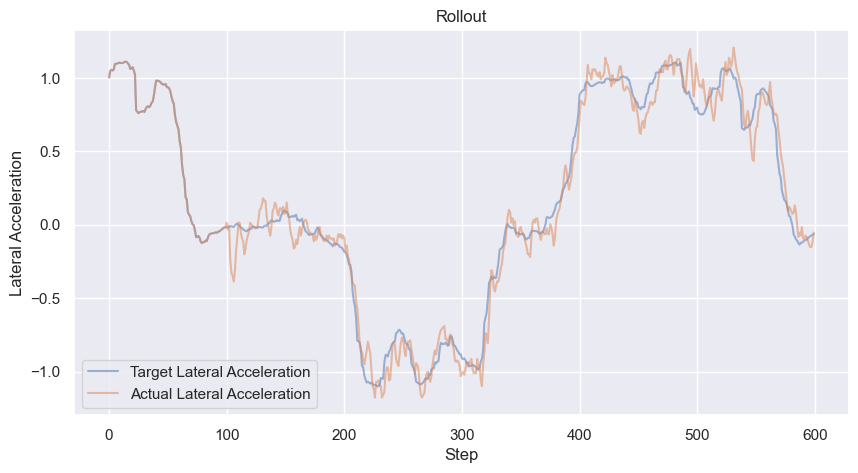

In [5]:
plot_rollout(sim)

In [6]:
# Baseline: Evaluate PID on test set
import glob
import numpy as np

test_files = sorted(glob.glob("./data/*.csv"))[:100]
costs = []

for f in test_files:
    controller = pid.Controller()
    sim = TinyPhysicsSimulator(model, f, controller=controller, debug=False)
    cost = sim.rollout()
    costs.append(cost['total_cost'])

print(f"PID baseline (n={len(costs)})")
print(f"Mean: {np.mean(costs):.2f}")
print(f"Std:  {np.std(costs):.2f}")
print(f"Min:  {np.min(costs):.2f}")
print(f"Max:  {np.max(costs):.2f}")
print(f"Median: {np.median(costs):.2f}")
print(f"\nTarget: <45 (winner)")
print(f"Gap: {np.mean(costs) - 45:.2f}")


PID baseline (n=100)
Mean: 80.44
Std:  61.71
Min:  4.97
Max:  374.89
Median: 67.73

Target: <45 (winner)
Gap: 35.44


In [8]:
# Online RL Controller Design
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tinyphysics import STEER_RANGE

class SimplePolicy(nn.Module):
    def __init__(self, input_dim=10, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
            nn.Tanh()
        )
        # Small init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=0.1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.net(x) * STEER_RANGE[1]  # Scale to action space

class OnlineController:
    def __init__(self):
        self.policy = SimplePolicy()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-4)
        self.replay_buffer = deque(maxlen=10000)
        self.explore_std = 0.1  # Exploration noise
        
    def get_state(self, target_lataccel, current_lataccel, state, future_plan):
        """Build minimal state representation"""
        error = target_lataccel - current_lataccel
        eps = 1e-6
        
        # Current
        curv_now = (target_lataccel - state.roll_lataccel) / (state.v_ego ** 2 + eps)
        
        # Near-term future (next 5 steps)
        future_curvs = []
        for t in range(5):
            if t < len(future_plan.lataccel):
                lat = future_plan.lataccel[t]
                roll = future_plan.roll_lataccel[t]
                v = future_plan.v_ego[t]
                curv = (lat - roll) / (v ** 2 + eps)
                future_curvs.append(curv)
            else:
                future_curvs.append(0.0)
        
        return np.array([
            error,
            current_lataccel,
            state.v_ego / 30.0,  # Normalize
            state.a_ego / 5.0,
            curv_now
        ] + future_curvs, dtype=np.float32)
    
    def act(self, state_vec, explore=True):
        """Get action from policy"""
        state_tensor = torch.FloatTensor(state_vec).unsqueeze(0)
        with torch.no_grad():
            action = self.policy(state_tensor).item()
        
        if explore:
            action += np.random.normal(0, self.explore_std)
        
        return np.clip(action, STEER_RANGE[0], STEER_RANGE[1])
    
    def update(self, batch_size=128):
        """Learn from replay buffer"""
        if len(self.replay_buffer) < batch_size:
            return 0.0
        
        # Sample batch
        batch = random.sample(self.replay_buffer, batch_size)
        states = torch.FloatTensor([s for s, a, r in batch])
        actions = torch.FloatTensor([a for s, a, r in batch])
        returns = torch.FloatTensor([r for s, a, r in batch])
        
        # Predict actions
        pred_actions = self.policy(states).squeeze()
        
        # Loss: weighted MSE (weight by returns)
        # Good returns → learn to reproduce that action
        weights = torch.exp(returns / returns.std())  # Exponential weighting
        loss = (weights * (pred_actions - actions) ** 2).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()

print("Online RL controller designed")
print("State: 10D (error, current_lat, velocity, accel, 6 curvatures)")
print("Updates: after each episode via replay buffer")


Online RL controller designed
State: 10D (error, current_lat, velocity, accel, 6 curvatures)
Updates: after each episode via replay buffer


In [17]:
# Training loop
import random
from controllers import BaseController
from tinyphysics import LAT_ACCEL_COST_MULTIPLIER

class RLControllerWrapper(BaseController):
    def __init__(self, rl_controller, explore=True):
        self.rl = rl_controller
        self.explore = explore
        self.trajectory = []  # Store (state, action) pairs
        
    def update(self, target_lataccel, current_lataccel, state, future_plan):
        state_vec = self.rl.get_state(target_lataccel, current_lataccel, state, future_plan)
        action = self.rl.act(state_vec, explore=self.explore)
        self.trajectory.append((state_vec, action))
        return action

# Initialize
rl_agent = OnlineController()
train_files = sorted(glob.glob("./data/*.csv"))[:50]

print("Training online RL agent...")
print("="*60)

costs = []
losses = []

for episode in range(200):
    # Sample file
    data_file = random.choice(train_files)
    
    # Rollout
    controller = RLControllerWrapper(rl_agent, explore=True)
    sim = TinyPhysicsSimulator(model, data_file, controller=controller, debug=False)
    
    # Collect trajectory with rewards
    step_idx = sim.step_idx
    for _ in range(step_idx, len(sim.data)):
        sim.step()
        
        # Compute reward
        if sim.step_idx >= CONTROL_START_IDX:
            error = sim.target_lataccel_history[-1] - sim.current_lataccel_history[-1]
            jerk = 0.0
            if len(sim.current_lataccel_history) >= 2:
                jerk = (sim.current_lataccel_history[-1] - sim.current_lataccel_history[-2]) / 0.1
            
            lat_cost = (error ** 2) * 100.0 * LAT_ACCEL_COST_MULTIPLIER
            jerk_cost = (jerk ** 2) * 100.0
            reward = -(lat_cost + jerk_cost)
        else:
            reward = 0.0
    
    # Compute returns and store in replay buffer
    returns = []
    R = 0
    gamma = 0.99
    for i in reversed(range(len(controller.trajectory))):
        if i >= CONTROL_START_IDX - step_idx:
            R = reward + gamma * R
        returns.insert(0, R)
    
    for (s, a), r in zip(controller.trajectory, returns):
        rl_agent.replay_buffer.append((s, a, r))
    
    # Learn from replay buffer
    loss = rl_agent.update(batch_size=128)
    losses.append(loss)
    
    # Evaluate
    final_cost = sim.compute_cost()
    costs.append(final_cost['total_cost'])
    
    if episode % 20 == 0:
        recent_cost = np.mean(costs[-20:]) if len(costs) >= 20 else costs[-1]
        recent_loss = np.mean(losses[-20:]) if len(losses) >= 20 else (losses[-1] if losses else 0)
        print(f"Ep {episode:3d} | Cost: {final_cost['total_cost']:.2f} | Avg20: {recent_cost:.2f} | Loss: {recent_loss:.4f} | Buffer: {len(rl_agent.replay_buffer)}")

print("="*60)
print(f"Final avg (last 50): {np.mean(costs[-50:]):.2f}")
print(f"Best: {np.min(costs):.2f}")

# Save
torch.save(rl_agent.policy.state_dict(), "online_rl_policy.pth")
print("Model saved")


Training online RL agent...
Ep   0 | Cost: 838.35 | Avg20: 838.35 | Loss: 0.0013 | Buffer: 578
Ep  20 | Cost: 747.80 | Avg20: 1346.89 | Loss: 0.0061 | Buffer: 10000
Ep  40 | Cost: 1132.41 | Avg20: 1162.32 | Loss: 0.0063 | Buffer: 10000
Ep  60 | Cost: 938.07 | Avg20: 1159.57 | Loss: 0.0052 | Buffer: 10000


KeyboardInterrupt: 

In [28]:
# Adapt beautiful_lander PPO to TinyPhysics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tinyphysics import STEER_RANGE, LAT_ACCEL_COST_MULTIPLIER, CONTROL_START_IDX

# Hyperparameters (from beautiful_lander, tuned for this task)
hidden_dim = 128
trunk_layers, head_layers = 1, 3
lr = 1e-3
gamma, gae_lambda, eps_clip = 0.99, 0.95, 0.2
entropy_coef = 0.001
batch_size, K_epochs = 2048, 10

device = torch.device('cpu')  # Keep simple for now

def tanh_log_prob(raw_action, dist):
    action = torch.tanh(raw_action)
    logp_gaussian = dist.log_prob(raw_action).sum(-1)
    return logp_gaussian - torch.log(1 - action**2 + 1e-6).sum(-1)

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, trunk_layers, head_layers):
        super().__init__()
        
        # Shared trunk
        trunk = [nn.Linear(state_dim, hidden_dim), nn.ReLU()]
        for _ in range(trunk_layers - 1):
            trunk.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        self.trunk = nn.Sequential(*trunk)
        
        # Actor head
        self.actor_layers = nn.Sequential(*[layer for _ in range(head_layers)
                                           for layer in [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]])
        self.actor_mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        
        # Critic head
        self.critic_layers = nn.Sequential(*[layer for _ in range(head_layers)
                                            for layer in [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]])
        self.critic_out = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        trunk_features = self.trunk(state)
        actor_feat = self.actor_layers(trunk_features)
        action_mean = self.actor_mean(actor_feat)
        action_std = self.log_std.exp()
        critic_feat = self.critic_layers(trunk_features)
        value = self.critic_out(critic_feat)
        return action_mean, action_std, value
    
    @torch.no_grad()
    def act(self, state, deterministic=False):
        state_tensor = torch.as_tensor(state, dtype=torch.float32).to(device)
        action_mean, action_std, _ = self(state_tensor)
        raw_action = action_mean if deterministic else torch.distributions.Normal(action_mean, action_std).sample()
        action = torch.tanh(raw_action) * STEER_RANGE[1]  # Scale to [-2, 2]
        return action.cpu().numpy(), state_tensor, raw_action

print("ActorCritic architecture loaded from beautiful_lander")


ActorCritic architecture loaded from beautiful_lander


In [29]:
# PPO class (from beautiful_lander)
class PPO:
    def __init__(self, actor_critic, lr, gamma, lamda, K_epochs, eps_clip, batch_size, entropy_coef):
        self.actor_critic = actor_critic
        self.optimizer = optim.Adam(actor_critic.parameters(), lr=lr)
        self.gamma, self.lamda, self.K_epochs = gamma, lamda, K_epochs
        self.eps_clip, self.batch_size, self.entropy_coef = eps_clip, batch_size, entropy_coef
        self.states, self.actions = [], []

    def select_action(self, state):
        action_np, state_tensor, raw_action = self.actor_critic.act(state, deterministic=False)
        self.states.append(state_tensor)
        self.actions.append(raw_action)
        return action_np

    def compute_advantages(self, rewards, state_values, is_terminals):
        T = len(rewards)
        advantages = torch.zeros(T, device=rewards.device)
        gae = torch.tensor(0.0, device=rewards.device)
        state_values_pad = torch.cat([state_values, state_values[-1:]], dim=0)
        
        for t in reversed(range(T)):
            delta = rewards[t] + self.gamma * state_values_pad[t + 1] * (1 - is_terminals[t]) - state_values_pad[t]
            gae = delta + self.gamma * self.lamda * (1 - is_terminals[t]) * gae
            advantages[t] = gae
        
        returns = advantages + state_values_pad[:-1]
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return advantages, returns
    
    def compute_losses(self, batch_states, batch_actions, batch_logprobs, batch_advantages, batch_returns):
        action_means, action_stds, state_values = self.actor_critic(batch_states)
        dist = torch.distributions.Normal(action_means, action_stds)
        action_logprobs = tanh_log_prob(batch_actions, dist)
        ratios = torch.exp(action_logprobs - batch_logprobs)
        actor_loss = -torch.min(ratios * batch_advantages, 
                                torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * batch_advantages).mean()
        critic_loss = F.mse_loss(state_values.squeeze(-1), batch_returns)
        entropy = dist.entropy().sum(-1).mean()
        return actor_loss + critic_loss - self.entropy_coef * entropy
    
    def update(self, rewards, dones):
        with torch.no_grad():
            rewards = torch.as_tensor(np.array(rewards), dtype=torch.float32).to(device)
            is_terms = torch.as_tensor(np.array(dones), dtype=torch.float32).to(device)
            old_states = torch.cat(self.states)
            old_actions = torch.cat(self.actions)
            action_means, action_stds, old_state_values = self.actor_critic(old_states)
            old_logprobs = tanh_log_prob(old_actions, torch.distributions.Normal(action_means, action_stds))
            old_state_values = old_state_values.squeeze(-1)
            advantages, returns = self.compute_advantages(rewards, old_state_values, is_terms)
        
        dataset = TensorDataset(old_states, old_actions, old_logprobs, advantages, returns)
        for _ in range(self.K_epochs):
            for batch in DataLoader(dataset, batch_size=self.batch_size, shuffle=True):
                self.optimizer.zero_grad()
                self.compute_losses(*batch).backward()
                torch.nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_norm=0.5)
                self.optimizer.step()
        
        self.states, self.actions = [], []

print("PPO class loaded")


PPO class loaded


In [30]:
# TinyPhysics controller wrapper + state builder
from controllers import BaseController

def build_state(target_lataccel, current_lataccel, state, future_plan):
    """Start simple: reactive control only"""
    error = target_lataccel - current_lataccel
    eps = 1e-6
    
    # Current curvature demand
    curv_now = (target_lataccel - state.roll_lataccel) / (state.v_ego ** 2 + eps)
    
    # Reactive state: 5D
    return np.array([
        error,
        current_lataccel,
        state.v_ego,
        state.a_ego,
        curv_now
    ], dtype=np.float32)

class PPOController(BaseController):
    def __init__(self, ppo):
        self.ppo = ppo
        
    def update(self, target_lataccel, current_lataccel, state, future_plan):
        state_vec = build_state(target_lataccel, current_lataccel, state, future_plan)
        action = self.ppo.select_action(state_vec)
        return float(action.item())

print("State: 56D = [error, current_lat, roll, v, a, curv_now] + 50 future curvatures")


State: 56D = [error, current_lat, roll, v, a, curv_now] + 50 future curvatures


In [ ]:
# Training loop
state_dim, action_dim = 5, 1  # Reactive: 5D state
actor_critic = ActorCritic(state_dim, action_dim, hidden_dim, trunk_layers, head_layers).to(device)
ppo = PPO(actor_critic, lr, gamma, gae_lambda, K_epochs, eps_clip, batch_size, entropy_coef)

train_files = sorted(glob.glob("./data/*.csv"))[:100]
n_epochs = 50
episodes_per_epoch = 20

print("Training PPO on TinyPhysics...")
print(f"Files: {len(train_files)}, Epochs: {n_epochs}, Episodes/epoch: {episodes_per_epoch}")
print("="*60)

epoch_costs = []

for epoch in range(n_epochs):
    # Collect trajectories
    epoch_rewards, epoch_dones = [], []
    episode_costs = []
    
    for ep in range(episodes_per_epoch):
        data_file = np.random.choice(train_files)
        controller = PPOController(ppo)
        sim = TinyPhysicsSimulator(model, data_file, controller=controller, debug=False)
        
        # Collect rewards per timestep
        step_rewards, step_dones = [], []
        
        for step_idx in range(sim.step_idx, len(sim.data)):
            sim.step()
            
            # Compute reward
            if sim.step_idx >= CONTROL_START_IDX:
                error = sim.target_lataccel_history[-1] - sim.current_lataccel_history[-1]
                jerk = 0.0
                if len(sim.current_lataccel_history) >= 2:
                    jerk = (sim.current_lataccel_history[-1] - sim.current_lataccel_history[-2]) / 0.1
                
                lat_cost = (error ** 2) * 100.0 * LAT_ACCEL_COST_MULTIPLIER
                jerk_cost = (jerk ** 2) * 100.0
                reward = -(lat_cost + jerk_cost) / 100.0  # Scale for better gradients
            else:
                reward = 0.0
            
            step_rewards.append(reward)
            step_dones.append(0.0)  # Mark as non-terminal
        
        step_dones[-1] = 1.0  # Mark last step as terminal
        
        epoch_rewards.extend(step_rewards)
        epoch_dones.extend(step_dones)
        
        cost = sim.compute_cost()
        episode_costs.append(cost['total_cost'])
    
    # PPO update
    ppo.update(epoch_rewards, epoch_dones)
    
    # Log
    mean_cost = np.mean(episode_costs)
    epoch_costs.append(mean_cost)
    
    if epoch % 5 == 0:
        recent_cost = np.mean(epoch_costs[-10:]) if len(epoch_costs) >= 10 else mean_cost
        std_val = actor_critic.log_std.exp().item()
        print(f"Epoch {epoch:2d} | Cost: {mean_cost:.2f} | Recent10: {recent_cost:.2f} | σ: {std_val:.3f}")

print("="*60)
print(f"Final cost (last 10): {np.mean(epoch_costs[-10:]):.2f}")
print(f"Best: {np.min(epoch_costs):.2f}")

torch.save(actor_critic.state_dict(), "ppo_policy.pth")
print("Model saved to ppo_policy.pth")


Training PPO on TinyPhysics...
Files: 100, Epochs: 50, Episodes/epoch: 20


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 56x128)